# Install the necessary packages

In [ ]:
pip install wheel
pip install pipwin

pipwin install numpy
pipwin install pandas
pipwin install shapely
pipwin install gdal
pipwin install fiona
pipwin install pyproj
pipwin install six
pipwin install rtree
pipwin install geopandas

In [ ]:
!pip install geojson
!pip install shapely
!pip install geopandas
!pip install geojsonio

# Import the necessary packages

In [1]:
#to import the geojson as a pandas like dataframe
import geopandas as gpd
import os
import cv2
import random

# Exploratory Data Analysis

In [2]:
XVIEW_UTILS_PATH = r'C:\Users\bcper\Documents\GitHub'
TF_INSTALL_PATH = r'C:\Users\bcper\Documents\GitHub\models'
GEOJSON_FILE = 'xView_train.geojson'
CLASS_LABELS_FILE = 'Class Labels.txt'

In [3]:
#Filenames and locations
DATA_DIR_PATH = os.path.join(TF_INSTALL_PATH, 'workspace','data', '')

paths = {
    'WORK_PATH': os.path.join(TF_INSTALL_PATH, 'workspace'),
    'DATA_PATH': DATA_DIR_PATH,
    'IMAGE_PATH': r'C:\Users\bcper\Documents\GitHub\models\workspace\data\test_images'
}

files = {
    'GEOJSON_IN': os.path.join(paths['DATA_PATH'], GEOJSON_FILE),
    'GEOJSON_OUT': os.path.join(paths['DATA_PATH'], GEOJSON_FILE + '_' + 'rare'),
    'CLASS_LABELS': os.path.join(paths['DATA_PATH'], CLASS_LABELS_FILE)
}

In [4]:
#read in the geojson
regions = gpd.read_file(files['GEOJSON_IN'])

In [5]:
used_ids = regions.type_id.unique()

In [6]:
os.chdir(paths['DATA_PATH'])
#read in the class labels
class_dict = {}
file = open(files['CLASS_LABELS'], "r")

#create a class label dictionary
for line in file:
    key, value = line.split(':')
    class_dict[int(key)] = value.strip()
    
given_ids = [key for key, vals in class_dict.items()]

In [7]:
extra_classes = [item for item in used_ids if item not in given_ids]

print(extra_classes)

[75, 82]


In [8]:
#split the bounds box
names = ["x1", "y1", "x2", "y2"]
regions[names] = regions['bounds_imcoords'].str.split(',', expand=True)
regions[names] = regions[names].astype(int)
regions['bottom'] = regions.y2 - regions.y1
regions['top'] = regions.x2 - regions.x1
regions['area'] = regions.bottom * regions.top

In [10]:
#delete any rows which contain a bounding box with a small x or y dimension
prior = len(regions)

regions = regions[regions.top > 10]
regions = regions[regions.bottom > 10]

post = len(regions)
print('Removed {} small regions.'.format(prior-post))

prior = len(regions)
regions = regions[~regions.type_id.isin(extra_classes)]

post = len(regions)
print('Removed {} invalid id types.'.format(prior-post))


Removed 133384 small regions.
Removed 79 invalid id types.


array([[<AxesSubplot:title={'center':'ratio'}>]], dtype=object)

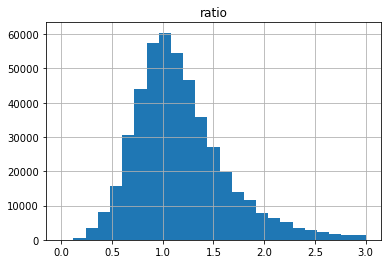

In [11]:
regions['ratio'] = regions.top / regions.bottom
regions.hist(column='ratio', bins=25,range=(0, 3))

array([[<AxesSubplot:title={'center':'area'}>]], dtype=object)

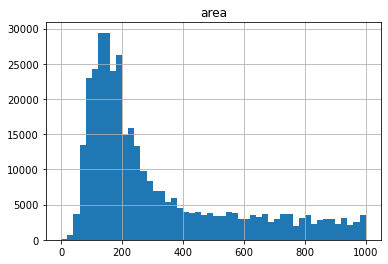

In [25]:
#the area of the bounding box in pixels
regions.hist(column='area', bins=50, range=(0,1000))

array([[<AxesSubplot:title={'center':'top'}>]], dtype=object)

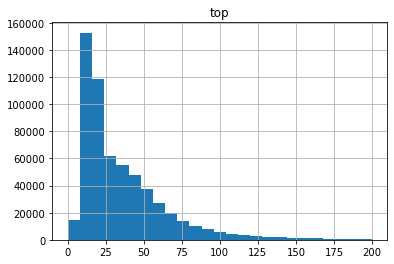

In [26]:
#the x size of the bounding box in pixels
regions.hist(column='top', bins=25, range=(0,200))

array([[<AxesSubplot:title={'center':'bottom'}>]], dtype=object)

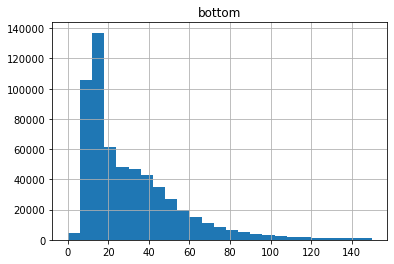

In [27]:
#the y size of the bounding box in pixels
regions.hist(column='bottom', bins=25, range=(0,150))

In [14]:
regions.type_id.value_counts()

73    316795
18    211664
23     12189
19      6975
24      5899
       ...  
56        70
57        64
75        51
82        28
33        17
Name: type_id, Length: 62, dtype: int64

array([[<AxesSubplot:title={'center':'type_id'}>]], dtype=object)

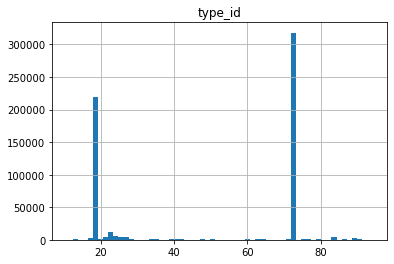

In [19]:
regions.hist(column='type_id', bins=60)

In [50]:
#save a new geoJSON file to be used later
regions.drop(columns=names)
regions.drop(columns=['bottom', 'top', 'ratio', 'area'])
regions.to_file(files['GEOJSON_OUT'], driver='GeoJSON')

# View images and overlay bounding boxes

In [30]:
image_name = '20.tif'

test_image = os.path.join(paths['IMAGE_PATH'], image_name)
test_regions = regions[regions['image_id'] == image_name]

In [31]:
print(test_image)

C:\Users\bcper\Documents\GitHub\models\workspace\data\test_images\20.tif


In [32]:
window_name = 'Image'
image = cv2.imread(test_image)

#create a color dictionary for the different ID types
color_dict = {}
type_set = test_regions.type_id.unique()

# font needed for text
font = cv2.FONT_HERSHEY_SIMPLEX

for type_id in type_set:
    color_dict[type_id] = (random.randint(0,255), random.randint(0,255), random.randint(0,255))


#loop through the region and find all of the objects, then place them on the image
for i in range(len(test_regions)):
    lst_int = [int(x) for x in test_regions.iloc[i]['bounds_imcoords'].split(",")]
    id_type = test_regions.type_id.iloc[i]
    topleft = (lst_int[0], lst_int[1])
    
    bottomright = (lst_int[2], lst_int[3])
    image = cv2.rectangle(image, topleft, bottomright, color=color_dict[id_type], thickness=1)
    #image = cv2.putText(image, ('ID: ' + str(id_type)), topleft)
    image = cv2.putText(image, class_dict[id_type], topleft, font, 
                   fontScale=0.5, color=color_dict[id_type], thickness=2)
    
# Display the image 
cv2.imshow(window_name, image) 
cv2.waitKey(0)
cv2.destroyAllWindows()